In [1]:
import pandas as pd
import numpy as np 

from collections import Counter
from itertools import combinations
from boruta import BorutaPy

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier,  kneighbors_graph
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader

import networkx as nx
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
paths = {
    "ADNIMERGE": "data/ADNIMERGE_17Apr2025.csv",
    "APOERES": "data/APOERES_17Apr2025.csv",
    "CDR": "data/CDR_24Apr2025.csv",
    "FAQ": "data/FAQ_24Apr2025.csv",
    "NEUROBAT": "data/NEUROBAT_17Apr2025.csv",
    "DEMOG": "data/RMT_PTDEMOG_17Apr2025.csv",
    "PSYCH": "data/UWNPSYCHSUM_17Apr2025.csv"
}

dfs = {name: pd.read_csv(path) for name, path in paths.items()}

df_adni = dfs["ADNIMERGE"]

C:\Users\plech\AppData\Local\Temp\ipykernel_29680\4170551003.py:11: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {name: pd.read_csv(path) for name, path in paths.items()}
C:\Users\plech\AppData\Local\Temp\ipykernel_29680\4170551003.py:11: DtypeWarning: Columns (79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {name: pd.read_csv(path) for name, path in paths.items()}


In [4]:
# Filter each dataset to include only baseline records (VISCODE == 'bl'),
# ensuring consistency by using only the first visit per subject across all files.
# This avoids mixing longitudinal follow-up data and keeps the target (DX_bl) aligned.
for name in dfs:
    if 'VISCODE' in dfs[name].columns:
        dfs[name] = dfs[name][dfs[name]['VISCODE'] == 'bl']

In [5]:
for name, df in dfs.items():
    has_rid = 'RID' in df.columns
    print(f"{name}: {'has RID' if has_rid else 'no RID'}")


ADNIMERGE: has RID
APOERES: has RID
CDR: has RID
FAQ: has RID
NEUROBAT: has RID
DEMOG: no RID
PSYCH: has RID


In [6]:
print(dfs['DEMOG'].columns)

Index(['RMT_PHASE', 'ADNIOnlineID', 'PTID', 'RMT_Timepoint', 'RMT_StatusDate',
       'Age_Baseline', 'Gender', 'LatinoEthnicity', 'Latino_MX', 'Latino_PR',
       'Latino_CB', 'Latino_Other', 'Race_AmerIndian', 'Race_Asian',
       'Race_AfricanAmerican', 'Race_PacificIslander', 'Race_White',
       'Race_Unknown', 'Race_PreferNotSay', 'RMT_Education',
       'RMT_ADI_NATRANK_v2021', 'RMT_ADI_STATERANK_v2021'],
      dtype='object')


In [7]:
# Remove feature DEMOG because it has no RID for merge
_ = dfs.pop('DEMOG', None)

In [8]:
dfs.keys()

dict_keys(['ADNIMERGE', 'APOERES', 'CDR', 'FAQ', 'NEUROBAT', 'PSYCH'])

In [9]:
# Start merging all datasets using 'RID' as the key.
# ADNIMERGE is used as the base since it contains the diagnosis labels (DX_bl).
# Perform a left join to retain all records from ADNIMERGE, even if some datasets lack entries for a given RID.

df_merged = dfs['ADNIMERGE']

for df in dfs:
    if df != 'ADNIMERGE':     
        df_merged = df_merged.merge(dfs[df], on='RID', how='left', suffixes=('', f'_{df.lower()}'))

# Drop duplicate columns created during merging to ensure feature uniqueness
df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]
# Keep only rows that have a known baseline diagnosis (DX_bl), required for supervised classification
df = df_merged.dropna(subset=['DX_bl'])


In [10]:
print(df_merged['DX_bl'].value_counts())
print(df_merged['DX'].value_counts())

df = df.drop('DX', axis=1)

DX_bl
LMCI    690
CN      542
EMCI    423
AD      411
SMC     353
Name: count, dtype: int64
DX
MCI         1101
CN           895
Dementia     413
Name: count, dtype: int64


In [11]:
# Map DX_bl string labels to integer codes
dx_mapping = {
    "CN": 0,     # Cognitively Normal
    "EMCI": 1,   # Early Mild Cognitive Impairment
    "LMCI": 2,    # Late Mild Cognitive Impairment
    "SMC": 3,    # Significant Memory Concern
    "AD": 4,     # Alzheimer's Disease
}


df['DX_bl'] = df['DX_bl'].map(dx_mapping)

In [12]:
df['DX_bl'].value_counts()

DX_bl
2    690
0    542
1    423
4    411
3    353
Name: count, dtype: int64

In [13]:
print("Original ADNIMERGE shape (all visits, unfiltered):", df_adni.shape)
print("Merged dataset shape (baseline only, before dropping missing targets):", df_merged.shape)
print("Final dataset shape (baseline only, with non-null diagnosis):", df.shape)

Original ADNIMERGE shape (all visits, unfiltered): (16421, 116)
Merged dataset shape (baseline only, before dropping missing targets): (2430, 273)
Final dataset shape (baseline only, with non-null diagnosis): (2419, 272)


In [14]:
df.shape

(2419, 272)

In [15]:
# Drop columns with more than 55% missing values
threshold = 0.55
missing_ratio = df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > threshold].index
df_clean = df.drop(columns=cols_to_drop)
df_clean.shape

(2419, 189)

In [16]:
cols_duplicated = {}
cols = df_clean.columns.tolist()
for x, y in combinations(cols, 2):
    df_x = df_clean[x]
    df_y = df_clean[y]
    
    n = 0
    for a, b in zip(df_x, df_y):
        if a == b or (pd.isna(a) and pd.isna(b)):
            n += 1
    if len(df_x)*0.9 < n:        
        cols_duplicated[x,y] = n

In [17]:
# sort_cols_duplicated = sorted(cols_duplicated.items())
# sort_cols_duplicated

sort_cols_duplicated = sorted(cols_duplicated.items(), key=lambda item: item[1], reverse=True)
sort_cols_duplicated, len(sort_cols_duplicated)

([(('COLPROT', 'ORIGPROT'), 2419),
  (('EXAMDATE', 'EXAMDATE_bl'), 2419),
  (('FDG', 'FDG_bl'), 2419),
  (('AV45', 'AV45_bl'), 2419),
  (('ABETA', 'ABETA_bl'), 2419),
  (('TAU', 'TAU_bl'), 2419),
  (('PTAU', 'PTAU_bl'), 2419),
  (('CDRSB', 'CDRSB_bl'), 2419),
  (('ADAS11', 'ADAS11_bl'), 2419),
  (('ADAS13', 'ADAS13_bl'), 2419),
  (('ADASQ4', 'ADASQ4_bl'), 2419),
  (('MMSE', 'MMSE_bl'), 2419),
  (('RAVLT_immediate', 'RAVLT_immediate_bl'), 2419),
  (('RAVLT_learning', 'RAVLT_learning_bl'), 2419),
  (('RAVLT_forgetting', 'RAVLT_forgetting_bl'), 2419),
  (('RAVLT_perc_forgetting', 'RAVLT_perc_forgetting_bl'), 2419),
  (('LDELTOTAL', 'LDELTOTAL_BL'), 2419),
  (('TRABSCOR', 'TRABSCOR_bl'), 2419),
  (('FAQ', 'FAQ_bl'), 2419),
  (('MOCA', 'MOCA_bl'), 2419),
  (('EcogPtMem', 'EcogPtMem_bl'), 2419),
  (('EcogPtLang', 'EcogPtLang_bl'), 2419),
  (('EcogPtVisspat', 'EcogPtVisspat_bl'), 2419),
  (('EcogPtPlan', 'EcogPtPlan_bl'), 2419),
  (('EcogPtOrgan', 'EcogPtOrgan_bl'), 2419),
  (('EcogPtDivatt',

In [18]:
pd.options.display.max_columns = None
df_clean

,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,TRABSCOR,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FLDSTRENG,FSVERSION,IMAGEUID,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,mPACCdigit,mPACCtrailsB,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,ADASQ4_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,LDELTOTAL_BL,TRABSCOR_bl,FAQ_bl,mPACCdigit_bl,mPACCtrailsB_bl,FLDSTRENG_bl,FSVERSION_bl,IMAGEUID_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp,PHASE_faq,PTID_faq,VISCODE_faq,VISCODE2_faq,VISDATE_faq,SOURCE,FAQFINAN,FAQFORM,FAQSHOP,FAQGAME,FAQBEVG,FAQMEAL,FAQEVENT,FAQTV,FAQREM,FAQTRAVL,FAQTOTAL,ID_faq,SITEID_faq,USERDATE_faq,update_stamp_faq,PHASE_neurobat,PTID_neurobat,VISCODE_neurobat,VISCODE2_neurobat,VISDATE_neurobat,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR_neurobat,TRABERRCOM,TRABERROM,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,ID_neurobat,SITEID_neurobat,USERDATE_neurobat,update_stamp_neurobat,PHASE_psych,VISCODE_psych,VISCODE2_psych,EXAMDATE_psych,ADNI_MEM,ADNI_EF,ADNI_LAN,ADNI_VS,ADNI_EF2,update_stamp_psych
0,2,ADNI1,ADNI1,011_S_0002,11,bl,2005-09-08,0,74.3,Male,16,Not Hisp/Latino,White,Married,0.0,1.33615,NaN,NaN,NaN,NaN,0.0,10.67,18.67,5.0,28.0,44.0,4.0,6.0,54.5455,10.0,112.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,35475.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,-4.310280,-4.114430,2005-09-08,0.0,10.67,18.67,5.0,28.0,44.0,4.0,6.0,54.5455,10.0,112.0,0.0,-4.310280,-4.114430,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,35475.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.33615,NaN,0.0,0.0,0,0,2023-07-07 04:59:40.0,ADNI1,011_S_0002,bl,bl,2005-09-08,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,107.0,2005-09-08,2005-09-08 00:00:00.0,ADNI1,011_S_0002,bl,bl,2005-09-08,1.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,7.0,0.0,7.0,0.0,9.0,0.0,10.0,0.0,11.0,0.0,5.0,2.0,4.0,1.0,15.0,2.0,0.0,29.0,0.0,0.0,112.0,1.0,0.0,5.0,4.0,6.0,0.0,16.0,30.0,107.0,2005-09-09,2014-08-26 16:22:44.0,ADNI1,bl,bl,2005-09-08,0.405,-0.041,0.140,0.739,-0.310,2023-12-11 14:53:52.0
1,3,ADNI1,ADNI1,011_S_0003,11,bl,2005-09-12,4,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.10860,NaN,741.5,239.7,22.83,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,148.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,32237.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,-16.244900,-15.829900,2005-09-12,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,148.0,10.0,-16.244900,-15.829900,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,32237.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.10860,NaN,0.0,0.0,0,0,2023-07-07 04:59:40.0,ADNI1,011_S_0003,bl,bl,2005-09-12,1.0,2.0,3.0,2.0,3.0,1.0,1.0,4.0,3.0,3.0,4.0,10.0,8

In [19]:
drop_cols = [
    "COLPROT",
    "EXAMDATE",
    "PHASE_faq",
    "PTID_faq",
    "RID",
    "USERDATE_faq",
    "USERDATE_neurobat",
    "VISCODE",
    "VISCODE_faq",
    "VISDATE_faq",
    "update_stamp",
    "update_stamp_faq",
    "update_stamp_neurobat",
    "update_stamp_psych",
]
others_Cols = []
for (x, y), n in sort_cols_duplicated:
    if not y in drop_cols:
        drop_cols.append(y)

df = df_clean.drop(columns=drop_cols)
df


,PTID,SITE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,TRABSCOR,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FLDSTRENG,FSVERSION,IMAGEUID,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,mPACCdigit,mPACCtrailsB,Years_bl,SOURCE,FAQFINAN,FAQFORM,FAQSHOP,FAQGAME,FAQBEVG,FAQMEAL,FAQEVENT,FAQTV,FAQREM,FAQTRAVL,FAQTOTAL,ID_faq,SITEID_faq,CLOCKCIRC,CLOCKSYM,CLOCKTIME,CLOCKSCOR,COPYSCOR,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,TRAASCOR,TRAAERRCOM,TRABSCOR_neurobat,TRABERRCOM,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,ID_neurobat,ADNI_MEM,ADNI_EF,ADNI_LAN,ADNI_VS,ADNI_EF2
0,011_S_0002,11,0,74.3,Male,16,Not Hisp/Latino,White,Married,0.0,1.33615,NaN,NaN,NaN,NaN,0.0,10.67,18.67,5.0,28.0,44.0,4.0,6.0,54.5455,10.0,112.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,35475.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,-4.310280,-4.114430,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,107.0,1.0,0.0,1.0,4.0,5.0,7.0,0.0,7.0,0.0,9.0,0.0,10.0,0.0,11.0,0.0,5.0,2.0,4.0,1.0,15.0,2.0,29.0,0.0,112.0,1.0,5.0,4.0,6.0,0.0,16.0,30.0,0.405,-0.041,0.140,0.739,-0.310
1,011_S_0003,11,4,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.10860,NaN,741.5,239.7,22.83,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,148.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,32237.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,-16.244900,-15.829900,0.0,1.0,2.0,3.0,2.0,3.0,1.0,1.0,4.0,3.0,3.0,4.0,10.0,8.0,107.0,1.0,0.0,0.0,2.0,4.0,3.0,0.0,6.0,0.0,4.0,0.0,5.0,0.0,4.0,0.0,3.0,1.0,1.0,2.0,10.0,0.0,57.0,0.0,148.0,1.0,0.0,0.0,1.0,0.0,11.0,36.0,-1.021,-1.144,-1.368,-0.880,-1.062
2,022_S_0004,22,2,67.5,Male,10,Hisp/Latino,White,Married,0.0,NaN,NaN,1501.0,153.1,13.29,1.0,14.33,21.33,6.0,27.0,37.0,7.0,4.0,36.3636,4.0,271.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,64631.0,39605.0,6869.0,1154980.0,3983.0,19036.0,19615.0,1679440.0,-8.421500,-9.449350,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,10.0,1.0,0.0,1.0,4.0,5.0,4.0,0.0,6.0,1.0,8.0,1.0,8.0,1.0,11.0,0.0,6.0,0.0,2.0,1.0,22.0,0.0,67.0,1.0,271.0,3.0,7.0,6.0,13.0,1.0,NaN,140.0,-0.009,-0.934,0.339,-0.739,-1.181
3,011_S_0005,11,0,73.7,Male,16,Not Hisp/Latino,White,Married,0.0,1.25956,NaN,547.3,337.0,33.43,0.0,8.67,14.67,4.0,29.0,37.0,4.0,4.0,44.4444,12.0,90.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,32246.0,34062.0,7075.0,1116630.0,4433.0,24788.0,21614.0,1640770.0,-1.888680,-1.565830,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,107.0,1.0,1.0,1.0,5.0,5.0,5.0,1.0,6.0,1.0,9.0,0.0,8.0,0.0,9.0,0.0,4.0,0.0,4.0,1.0,19.0,1.0,50.0,0.0,90.0,1.0,5.0,5.0,15.0,1.0,5.0,32.0,0.743,0.165,0.259,0.739,-0.152
4,100_S_0006,100,2,80.4,Female,13,Not Hisp/Latino,White,Married,0.0,NaN,NaN,NaN,NaN,NaN,0.5,18.67,25.67,7.0,25.0,30.0,1.0,5.0,83.3333,3.0,168.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,33025.0,39826.0,5348.0,927510.0,2277.0,17963.0,17802.0,1485830.0,-10.141700,-10.910900,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,44.0,4.0,1.0,1.0,0.0,4.0,4.0,5.0,0.0,6.0,0.0,6.0,0.0,7.0,1.0,6.0,0.0,4.0,4.0,4.0,0.0,13.0,4.0,49.0,0.0,168.0,1.0,1.0,0.0,7.0,1.0,17.0,182.0,-0.219,-0.463,-0.260,-0.880,-0.498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [20]:
non_numeric_features = df.select_dtypes(exclude=['number']).columns
print("Non-numeric features:", non_numeric_features)

Non-numeric features: Index(['PTID', 'PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'ABETA', 'TAU',
       'PTAU', 'FLDSTRENG', 'FSVERSION'],
      dtype='object')


In [21]:
df_non_numeric = df[non_numeric_features]
display(df_non_numeric.head())
print(df_non_numeric.info())

,PTID,PTGENDER,PTETHCAT,PTRACCAT,PTMARRY,ABETA,TAU,PTAU,FLDSTRENG,FSVERSION
0,011_S_0002,Male,Not Hisp/Latino,White,Married,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
1,011_S_0003,Male,Not Hisp/Latino,White,Married,741.5,239.7,22.83,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
2,022_S_0004,Male,Hisp/Latino,White,Married,1501.0,153.1,13.29,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
3,011_S_0005,Male,Not Hisp/Latino,White,Married,547.3,337.0,33.43,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
4,100_S_0006,Female,Not Hisp/Latino,White,Married,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...


<class 'pandas.core.frame.DataFrame'>
Index: 2419 entries, 0 to 2428
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PTID       2419 non-null   object
 1   PTGENDER   2419 non-null   object
 2   PTETHCAT   2419 non-null   object
 3   PTRACCAT   2419 non-null   object
 4   PTMARRY    2418 non-null   object
 5   ABETA      1215 non-null   object
 6   TAU        1215 non-null   object
 7   PTAU       1215 non-null   object
 8   FLDSTRENG  1569 non-null   object
 9   FSVERSION  2333 non-null   object
dtypes: object(10)
memory usage: 207.9+ KB
None


In [22]:
df_non_numeric = df_non_numeric.drop('PTID', axis=1)

In [23]:
# Fill null values in categorical columns with the mode
for col in df_non_numeric.columns:
    mode = df_non_numeric[col].mode().iloc[0]
    df_non_numeric[col].fillna(mode, inplace=True)

display(df_non_numeric.head())
print(df_non_numeric.info())

C:\Users\plech\AppData\Local\Temp\ipykernel_29680\1062988513.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_non_numeric[col].fillna(mode, inplace=True)


,PTGENDER,PTETHCAT,PTRACCAT,PTMARRY,ABETA,TAU,PTAU,FLDSTRENG,FSVERSION
0,Male,Not Hisp/Latino,White,Married,>1700,<80,<8,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
1,Male,Not Hisp/Latino,White,Married,741.5,239.7,22.83,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
2,Male,Hisp/Latino,White,Married,1501.0,153.1,13.29,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
3,Male,Not Hisp/Latino,White,Married,547.3,337.0,33.43,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
4,Female,Not Hisp/Latino,White,Married,>1700,<80,<8,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...


<class 'pandas.core.frame.DataFrame'>
Index: 2419 entries, 0 to 2428
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PTGENDER   2419 non-null   object
 1   PTETHCAT   2419 non-null   object
 2   PTRACCAT   2419 non-null   object
 3   PTMARRY    2419 non-null   object
 4   ABETA      2419 non-null   object
 5   TAU        2419 non-null   object
 6   PTAU       2419 non-null   object
 7   FLDSTRENG  2419 non-null   object
 8   FSVERSION  2419 non-null   object
dtypes: object(9)
memory usage: 189.0+ KB
None


In [24]:
label_encoders = {}
for col in df_non_numeric.columns:
    df[col] = df[col].astype(str)  # Ensure all values are strings
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store the encoder in case we need inverse_transform later

print(f"Encoded {len(df_non_numeric.columns)} non-numeric features using LabelEncoder.")

Encoded 9 non-numeric features using LabelEncoder.


In [25]:
# Reset the display option to show a limited number of columns again
pd.reset_option('display.max_columns')
display(df.head())
print(df.info())

,PTID,SITE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,...,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,ID_neurobat,ADNI_MEM,ADNI_EF,ADNI_LAN,ADNI_VS,ADNI_EF2
0,011_S_0002,11,0,74.3,1,16,1,6,1,0.0,...,4.0,6.0,0.0,16.0,30.0,0.405,-0.041,0.140,0.739,-0.310
1,011_S_0003,11,4,81.3,1,18,1,6,1,1.0,...,0.0,1.0,0.0,11.0,36.0,-1.021,-1.144,-1.368,-0.880,-1.062
2,022_S_0004,22,2,67.5,1,10,0,6,1,0.0,...,6.0,13.0,1.0,NaN,140.0,-0.009,-0.934,0.339,-0.739,-1.181
3,011_S_0005,11,0,73.7,1,16,1,6,1,0.0,...,5.0,15.0,1.0,5.0,32.0,0.743,0.165,0.259,0.739,-0.152
4,100_S_0006,100,2,80.4,0,13,1,6,1,0.0,...,0.0,7.0,1.0,17.0,182.0,-0.219,-0.463,-0.260,-0.880,-0.498


<class 'pandas.core.frame.DataFrame'>
Index: 2419 entries, 0 to 2428
Columns: 105 entries, PTID to ADNI_EF2
dtypes: float64(92), int64(12), object(1)
memory usage: 2.0+ MB
None


In [26]:
# Remove columns that have 90% of the same values
bad_col = []
for i, x in enumerate(df.columns):
    if sorted(list(df[x].value_counts(normalize = True).values))[-1] >= 0.9 :
        bad_col.append(x)
print("Before shape:", df.shape)
print("Bad columns:", bad_col)      
df = df.drop(columns=bad_col)
print("Shape after remove bad columns:", df.shape)

Before shape: (2419, 105)
Bad columns: ['PTETHCAT', 'Years_bl', 'FAQBEVG', 'CLOCKCIRC']
Shape after remove bad columns: (2419, 101)


In [27]:
df = df.drop('PTID', axis=1)

In [28]:
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
Index: 2419 entries, 0 to 2428
Data columns (total 100 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SITE                   2419 non-null   int64  
 1   DX_bl                  2419 non-null   int64  
 2   AGE                    2415 non-null   float64
 3   PTGENDER               2419 non-null   int64  
 4   PTEDUCAT               2419 non-null   int64  
 5   PTRACCAT               2419 non-null   int64  
 6   PTMARRY                2419 non-null   int64  
 7   APOE4                  2210 non-null   float64
 8   FDG                    1513 non-null   float64
 9   AV45                   1132 non-null   float64
 10  ABETA                  2419 non-null   int64  
 11  TAU                    2419 non-null   int64  
 12  PTAU                   2419 non-null   int64  
 13  CDRSB                  2419 non-null   float64
 14  ADAS11                 2409 non-null   float64
 15  ADAS13  

              SITE        DX_bl          AGE     PTGENDER     PTEDUCAT  \
count  2419.000000  2419.000000  2415.000000  2419.000000  2419.000000   
mean     87.534518     1.862753    72.917805     0.525010    16.050021   
std     142.873376     1.370617     7.367341     0.499477     2.735133   
min       2.000000     0.000000    50.400000     0.000000     4.000000   
25%      22.000000     1.000000    68.000000     0.000000    14.000000   
50%      52.000000     2.000000    72.900000     1.000000    16.000000   
75%     126.000000     3.000000    78.100000     1.000000    18.000000   
max     941.000000     4.000000    91.400000     1.000000    20.000000   

          PTRACCAT      PTMARRY        APOE4          FDG         AV45  ...  \
count  2419.000000  2419.000000  2210.000000  1513.000000  1132.000000  ...   
mean      5.542786     1.288962     0.553394     1.198979     1.208290  ...   
std       1.303162     1.033959     0.661356     0.161387     0.231877  ...   
min       0.00000

In [29]:
# Fill null values ​​of continuous columns with the mean
for col in df.columns:
    mean_value = df[col].mean()
    df[col].fillna(mean_value, inplace=True)


C:\Users\plech\AppData\Local\Temp\ipykernel_29680\3018776726.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_value, inplace=True)


In [30]:
df

,SITE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTRACCAT,PTMARRY,APOE4,FDG,AV45,...,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,ID_neurobat,ADNI_MEM,ADNI_EF,ADNI_LAN,ADNI_VS,ADNI_EF2
0,11,0,74.3,1,16,6,1,0.000000,1.336150,1.20829,...,4.0,6.0,0.0,16.000000,30.0,0.405,-0.041,0.140,0.739,-0.310
1,11,4,81.3,1,18,6,1,1.000000,1.108600,1.20829,...,0.0,1.0,0.0,11.000000,36.0,-1.021,-1.144,-1.368,-0.880,-1.062
2,22,2,67.5,1,10,6,1,0.000000,1.198979,1.20829,...,6.0,13.0,1.0,12.505934,140.0,-0.009,-0.934,0.339,-0.739,-1.181
3,11,0,73.7,1,16,6,1,0.000000,1.259560,1.20829,...,5.0,15.0,1.0,5.000000,32.0,0.743,0.165,0.259,0.739,-0.152
4,100,2,80.4,0,13,6,1,0.000000,1.198979,1.20829,...,0.0,7.0,1.0,17.000000,182.0,-0.219,-0.463,-0.260,-0.880,-0.498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,33,3,65.6,0,17,2,0,0.553394,1.198979,1.20829,...,0.0,15.0,0.0,5.000000,170226.0,2.978,2.087,0.960,0.739,2.026
2425,53,2,61.4,1,12,6,1,0.553394,1.198979,1.20829,...,2.0,8.0,6.0,11.000000,170105.0,-0.844,-1.490,-0.851,-0.080,-1.596
2426,35,2,64.6,0,12,5,4,0.553394,1.198979,1.20829,...,1.0,11.0,1.0,12.000000,171669.0,-0.232,0.310,0.606,-0.739,0.160
2427,82,1,68.9,0,18,2,2,0.553394,1.198979,1.20829,...,1.0,13.0,1.0,9.000000,173872.0,1.392,1.313,0.856,0.739,1.056


In [31]:
X = df.drop(columns=['DX_bl'])
y = df['DX_bl']

In [32]:
X.shape

(2419, 99)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)

# Boruta
boruta = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, random_state=42)
boruta.fit(X_train.values, y_train)

# find features that are important
selected_features = X_train.columns[boruta.support_].tolist()

X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	34
Tentative: 	23
Rejected: 	42
Iteration: 	9 / 100
Confirmed: 	34
Tentative: 	23
Rejected: 	42
Iteration: 	10 / 100
Confirmed: 	34
Tentative: 	23
Rejected: 	42
Iteration: 	11 / 100
Confirmed: 	34
Tentative: 	23
Rejected: 	42
Iteration: 	12 / 100
Confirmed: 	34
Tentative: 	18
Rejected: 	47
Iteration: 	13 / 100
Confirmed: 	34
Tentative: 	18
Rejected: 	47
Iteration: 	14 / 100
Confirmed: 	34
Tentative: 	18
Rejected: 	47
Iteration: 	15 / 100
Confirmed: 	34
Tentative: 	18
Rejected: 	47
Iteration: 	16 / 100
Confirmed: 	34
Tentative: 	

In [35]:
y_train.value_counts()

DX_bl
2    539
0    441
4    338
1    333
3    284
Name: count, dtype: int64

In [36]:
print(X_train_reduced.shape, X_test_reduced.shape)
all_coluns = list(X_train_reduced.columns)
all_coluns.append("DX_bl")
print(all_coluns, "\n")
display(X_train_reduced.head())

(1935, 35) (484, 35)
['AGE', 'PTEDUCAT', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'TRABSCOR', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG', 'FSVERSION', 'IMAGEUID', 'Hippocampus', 'mPACCdigit', 'mPACCtrailsB', 'FAQTOTAL', 'ID_faq', 'ID_neurobat', 'ADNI_MEM', 'DX_bl'] 



,AGE,PTEDUCAT,FDG,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_perc_forgetting,...,FLDSTRENG,FSVERSION,IMAGEUID,Hippocampus,mPACCdigit,mPACCtrailsB,FAQTOTAL,ID_faq,ID_neurobat,ADNI_MEM
1669,73.7,14,1.26462,2.0,8.00,13.00,4.0,30.0,31.0,50.0000,...,1,0,280556.0,7616.0,-1.54144,-1.37200,3.704969,33756.095326,34038.621622,0.365682
1566,70.3,12,1.29339,0.0,5.33,7.33,2.0,25.0,44.0,27.2727,...,0,2,55943.0,7655.0,-3.77611,-2.94483,0.000000,1146.000000,2794.000000,1.021000
544,76.6,18,1.17897,1.5,14.67,23.67,9.0,25.0,29.0,100.0000,...,0,2,66141.0,6098.0,-9.99856,-12.43850,7.000000,2030.000000,4294.000000,-0.653000
1374,82.5,14,1.27548,1.0,6.00,8.00,1.0,28.0,41.0,22.2222,...,1,0,223220.0,6254.0,-1.64140,-4.02235,3.000000,44.000000,174.000000,1.172000
1640,68.6,17,1.15018,2.0,12.00,18.00,6.0,26.0,37.0,80.0000,...,1,0,255405.0,6755.0,-7.28184,-6.02614,3.704969,33756.095326,34038.621622,0.365682


In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)
print(X_train_scaled.shape, X_test_scaled.shape)

(1935, 35) (484, 35)


### Model performance

In [38]:
# # #KNN
# # Finding the best k
# k_range = range(1, 31)
# k_scores = []

# for k in k_range:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
#     k_scores.append(scores.mean())

# plt.plot(k_range, k_scores)
# plt.xlabel('k value')
# plt.ylabel('Mean Accuracy')
# plt.title('K Selection')
# plt.grid(True)
# plt.show()

# best_k = k_range[np.argmax(k_scores)]
# print(f"Best k: {best_k}")

# # Training the final model
# best_knn = KNeighborsClassifier(n_neighbors=best_k)
# best_knn.fit(X_train_scaled, y_train)

# # Evaluating on the test set
# test_accuracy = best_knn.score(X_test_scaled, y_test)
# print(f"Test set accuracy: {test_accuracy:.4f}")

# # Predictions and evaluation
# y_pred = best_knn.predict(X_test_scaled)
# print('''
# "CN": 0,     # Cognitively Normal - Cognitivamente Normal
# "EMCI": 1,   # Early Mild Cognitive Impairment - Comprometimento Cognitivo Leve Inicial
# "LMCI": 2    # Late Mild Cognitive Impairment - Comprometimento Cognitivo Leve Avançado)
# "SMC": 3,    # Significant Memory Concern - Preocupação Significativa com a Memória
# "AD": 4,     # Alzheimer's Disease - Doença de Alzheimer''')

# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

# print("Classification Report:")
# print(classification_report(y_test, y_pred))

In [67]:
#Neural Network structure
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35, 128)  # 35 is the number features in df_train and 128 is the default value of neurons 
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 128) # Default values
        self.dropout2 = nn.Dropout(0.3)

        self.out = nn.Linear(128, 5) # default values and number of class output
        
    def forward(self, x):
        x = F.normalize(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.out(x)

Epoch 1, Loss: 1.6077
Epoch 2, Loss: 1.6007
Epoch 3, Loss: 1.5929
Epoch 4, Loss: 1.5856
Epoch 5, Loss: 1.5772
Epoch 6, Loss: 1.5701
Epoch 7, Loss: 1.5621
Epoch 8, Loss: 1.5528
Epoch 9, Loss: 1.5435
Epoch 10, Loss: 1.5360
Epoch 11, Loss: 1.5237
Epoch 12, Loss: 1.5150
Epoch 13, Loss: 1.5013
Epoch 14, Loss: 1.4917
Epoch 15, Loss: 1.4780
Epoch 16, Loss: 1.4634
Epoch 17, Loss: 1.4492
Epoch 18, Loss: 1.4337
Epoch 19, Loss: 1.4184
Epoch 20, Loss: 1.4012
Epoch 21, Loss: 1.3817
Epoch 22, Loss: 1.3653
Epoch 23, Loss: 1.3477
Epoch 24, Loss: 1.3249
Epoch 25, Loss: 1.3097
Epoch 26, Loss: 1.2885
Epoch 27, Loss: 1.2649
Epoch 28, Loss: 1.2486
Epoch 29, Loss: 1.2290
Epoch 30, Loss: 1.2083
Epoch 31, Loss: 1.1894
Epoch 32, Loss: 1.1713
Epoch 33, Loss: 1.1524
Epoch 34, Loss: 1.1303
Epoch 35, Loss: 1.1170
Epoch 36, Loss: 1.1023
Epoch 37, Loss: 1.0854
Epoch 38, Loss: 1.0730
Epoch 39, Loss: 1.0517
Epoch 40, Loss: 1.0447
Epoch 41, Loss: 1.0314
Epoch 42, Loss: 1.0147
Epoch 43, Loss: 1.0029
Epoch 44, Loss: 0.98

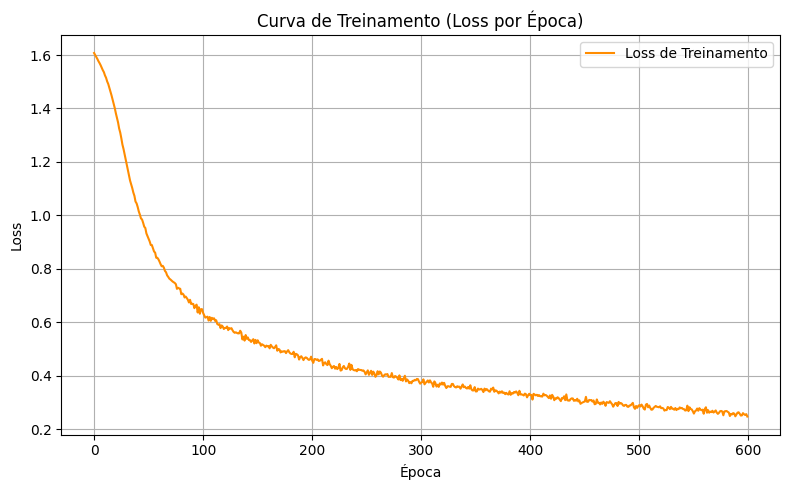

In [68]:
net = Net()

x_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train.values).long()
x_val_tensor = torch.from_numpy(X_test_scaled).float()
y_val_tensor = torch.from_numpy(y_test.values).long()

optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


train_losses = []
val_losses = []

for epoch in range(600):
    net.train()
    optimizer.zero_grad()
    outputs = net(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
    
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Loss de Treinamento', color='darkorange')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Treinamento (Loss por Época)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Random Forest test set accuracy: 0.8740

"CN": 0,     # Cognitively Normal - Cognitivamente Normal
"EMCI": 1,   # Early Mild Cognitive Impairment - Comprometimento Cognitivo Leve Inicial
"LMCI": 2,   # Late Mild Cognitive Impairment - Comprometimento Cognitivo Leve Avançado
"SMC": 3,    # Significant Memory Concern - Preocupação Significativa com a Memória
"AD": 4,     # Alzheimer's Disease - Doença de Alzheimer

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       101
           1       0.84      0.93      0.88        90
           2       0.91      0.91      0.91       151
           3       0.77      0.78      0.78        69
           4       0.90      0.88      0.89        73

    accuracy                           0.87       484
   macro avg       0.87      0.87      0.87       484
weighted avg       0.88      0.87      0.87       484



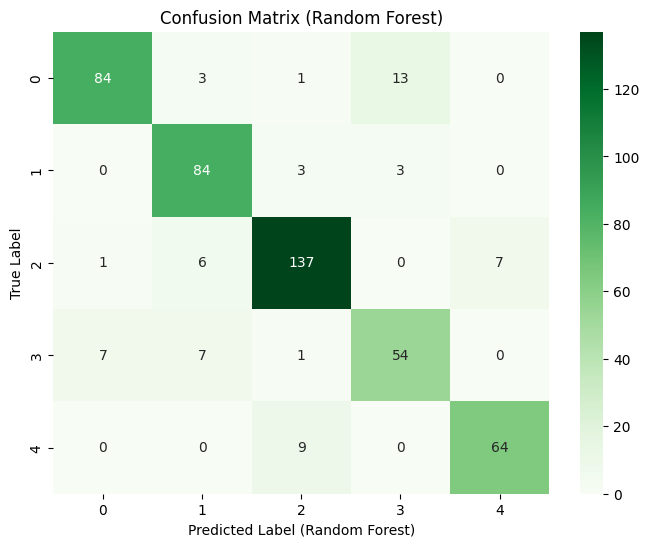

In [46]:
#Random forest

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest test set accuracy: {accuracy_rf:.4f}")

print('''
"CN": 0,     # Cognitively Normal - Cognitivamente Normal
"EMCI": 1,   # Early Mild Cognitive Impairment - Comprometimento Cognitivo Leve Inicial
"LMCI": 2,   # Late Mild Cognitive Impairment - Comprometimento Cognitivo Leve Avançado
"SMC": 3,    # Significant Memory Concern - Preocupação Significativa com a Memória
"AD": 4,     # Alzheimer's Disease - Doença de Alzheimer''')

# Display the classification report
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Display the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label (Random Forest)')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

gradientBoosting test set accuracy: 0.9029

"CN": 0,     # Cognitively Normal - Cognitivamente Normal
"EMCI": 1,   # Early Mild Cognitive Impairment - Comprometimento Cognitivo Leve Inicial
"LMCI": 2,    # Late Mild Cognitive Impairment - Comprometimento Cognitivo Leve Avançado
"SMC": 3,    # Significant Memory Concern - Preocupação Significativa com a Memória
"AD": 4,     # Alzheimer's Disease - Doença de Alzheimer

Classification Report (gradientBoosting):
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       101
           1       0.90      0.93      0.92        90
           2       0.93      0.94      0.94       151
           3       0.79      0.87      0.83        69
           4       0.93      0.90      0.92        73

    accuracy                           0.90       484
   macro avg       0.90      0.90      0.90       484
weighted avg       0.90      0.90      0.90       484



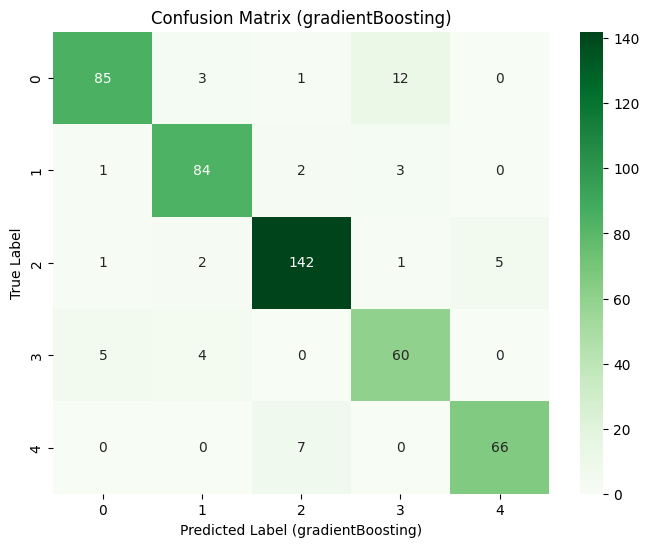

In [47]:
#GradientBoosting

gBosting_model = GradientBoostingClassifier(random_state=42, learning_rate=0.17)
gBosting_model = gBosting_model.fit(X_train_scaled, y_train)

y_pred_gBoost = gBosting_model.predict(X_test_scaled)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_gBoost)
print(f"gradientBoosting test set accuracy: {accuracy_rf:.4f}")

print('''
"CN": 0,     # Cognitively Normal - Cognitivamente Normal
"EMCI": 1,   # Early Mild Cognitive Impairment - Comprometimento Cognitivo Leve Inicial
"LMCI": 2,    # Late Mild Cognitive Impairment - Comprometimento Cognitivo Leve Avançado
"SMC": 3,    # Significant Memory Concern - Preocupação Significativa com a Memória
"AD": 4,     # Alzheimer's Disease - Doença de Alzheimer''')

# Display the classification report
print("\nClassification Report (gradientBoosting):")
print(classification_report(y_test, y_pred_gBoost))

# Display the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_gBoost)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label (gradientBoosting)')
plt.ylabel('True Label')
plt.title('Confusion Matrix (gradientBoosting)')
plt.show()